# Relationship between age and income

The goal is to investigate the relationship between age and income using US census data. The target of inference is the linear regression coefficient when regressing yearly income in dollars on age, while controlling for sex. The data from California in the year 2019 is downloaded through the Folktables interface (1). Predictions of income are made by training a gradient boosting tree via XGBoost (2) on the previous year’s data.

1. F. Ding, M. Hardt, J. Miller, L. Schmidt, “Retiring adult: New datasets for fair machine learning” in Advances in Neural Information Processing Systems 34 (2021), pp. 6478–6490.
2. T. Chen, C. Guestrin, “XGBoost: A scalable tree boosting system” in Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (2016), pp. 785–794.

### Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci
from statsmodels.regression.linear_model import OLS
from scipy.optimize import brentq
from tqdm import tqdm
from utils import *
import pdb

### Import the census income data set

Load the data. The data set contains reported income (```Y```), predicted income (```Yhat```), and age and sex (```X```).

In [2]:
dataset_folder = "../data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [3]:
alpha = 0.1
coord = 0  # Choose between 0, 1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(100, 2000, 5).astype(
    int
)  # Test for different numbers of labeled ballots
num_trials = 100
# Compute ground truth
theta_star = OLS(Y_total, exog=X_total).fit().params
savename = "census_income_tuned"

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```tuned PPI```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total[rand_idx[:n]],
            Yhat_total[rand_idx[n:]],
        )
        ppi_ci_tuned = ppi_ols_ci(
            _X,
            _Y,
            _Yhat,
            _X_unlabeled,
            _Yhat_unlabeled,
            alpha=alpha,
            coord=coord,
        )
        ppi_ci = ppi_ols_ci(
            _X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha, lam=1
        )
        classical_ci = ppi_ols_ci(
            _X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha, lam=0
        )

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coord],
                        "upper": ppi_ci[1][coord],
                        "included": (
                            ppi_ci_tuned[0][coord] <= theta_star[coord]
                        )
                        & (ppi_ci_tuned[1][coord] >= theta_star[coord]),
                        "trial": j,
                    }
                ]
            )
        ]

        results += [
            pd.DataFrame(
                [
                    {
                        "method": "classical",
                        "n": n,
                        "lower": classical_ci[0][coord],
                        "upper": classical_ci[1][coord],
                        "included": (
                            classical_ci[0][coord] <= theta_star[coord]
                        )
                        & (classical_ci[1][coord] >= theta_star[coord]),
                        "trial": j,
                    }
                ]
            )
        ]

        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI++",
                        "n": n,
                        "lower": ppi_ci_tuned[0][coord],
                        "upper": ppi_ci_tuned[1][coord],
                        "included": (
                            ppi_ci_tuned[0][coord] <= theta_star[coord]
                        )
                        & (ppi_ci_tuned[1][coord] >= theta_star[coord]),
                        "trial": j,
                    }
                ]
            )
        ]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]
os.makedirs(".cache/", exist_ok=True)
df.to_csv(".cache/" + savename + ".csv")

100%|██████████| 5/5 [49:18<00:00, 591.67s/it]


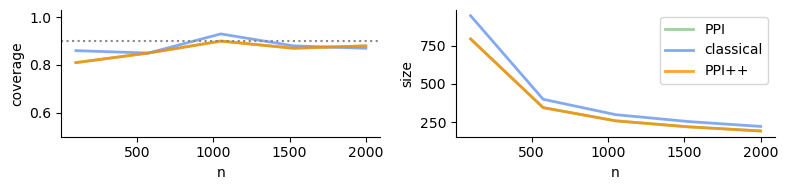

In [5]:
palette = {
    "PPI++": "darkorange",
    "PPI": "#83C980",
    "classical": "cornflowerblue",
}
linewidth = 2

fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(8, 2), sharex=True, sharey=False
)
cvg_ax = axs[0]
sz_ax = axs[1]
sns.lineplot(
    ax=cvg_ax,
    data=df,
    x="n",
    y="included",
    linewidth=linewidth,
    errorbar=None,
    hue="method",
    legend=False,
    palette=palette,
    alpha=0.8,
)
sns.lineplot(
    ax=sz_ax,
    data=df,
    x="n",
    y="width",
    linewidth=linewidth,
    errorbar=None,
    hue="method",
    legend=True,
    palette=palette,
    alpha=0.8,
)
cvg_ax.set_ylabel("coverage")
cvg_ax.set_ylim([0.5, 1.03])
cvg_ax.axhline(y=1 - alpha, color="#888888", linestyle="dotted")
cvg_ax.set_xlabel("n")
sz_ax.set_ylabel("size")
sz_ax.set_xlabel("n")
sz_ax.legend_.set_title(None)
sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs("./plots", exist_ok=True)
plt.savefig("./plots/" + savename + ".pdf")